# Surrender Index

## Functions

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
def scoreDiff(row):
    if row['recTeam'] == row['awayTeam']:
        return row['homeScore'] - row['awayScore']
    else:
        return row['awayScore'] - row['homeScore']

In [4]:
def secSinceHalf(row):
    return 1800 - int(row['totTime'])

In [5]:
def fieldPosScore(row):
    if row['dist2goal'] >= 60:
        return 1.0
    elif row['dist2goal'] >= 50:
        return 1.1 ** (40 - row['dist2goal'])
    else:
        return 1.1**10 * 1.2**(50 - row['dist2goal'])

In [6]:
def distScore(row):
    if int(row['distance']) >= 10:
        return 0.2
    elif 7 <= row['distance'] <= 9:
        return 0.4
    elif 4 <= row['distance'] <= 6:
        return 0.6
    elif 2 <= row['distance'] <= 3:
        return 0.8
    else:
        return 1.0

In [7]:
def scoreDiffMult(pointdiff):
    if pointdiff > 0:
        return 1
    elif pointdiff == 0:
        return 2
    elif pointdiff < -8:
        return 3
    else:
        return 4

In [8]:
def timeMult(row):
    sec = secSinceHalf(row)
    PD = scoreDiff(row)
    
    if PD <= 0 and sec >= 0:
        return ((sec * 0.001)**3) + 1.
    else:
        return 1.

In [9]:
def surrenderIndex(row):
    pd = scoreDiff(row)
#     print(fieldPosScore(row),distScore(row),scoreDiffMult(pd),timeMult(row))
    return fieldPosScore(row) * distScore(row) * scoreDiffMult(pd) * timeMult(row)

## Punts

In [11]:
allData = pd.read_csv('all_post21.csv')
# s20Data = pd.read_csv('s20.csv')
# s21Data = pd.read_csv('s21.csv')

# allData = allData.append(s20Data)
# allData = allData.append(s21Data)

In [12]:
puntDF = allData[allData['play'].str.contains('Punt ')]

In [13]:
puntDF = puntDF.rename(columns = {'teamPoss':'recTeam'})

In [14]:
def fixAZBug(row): #Only for Punts!
    if row['recTeam'] == 'AZ':
        row['dist2goal'] = 100 - row['dist2goal']
        if row['homeTeam'] == 'AZ':
            row['side'] = row['awayTeam']
        else:
            row['side'] = row['homeTeam']
    return row

In [15]:
puntDF = puntDF.apply(lambda row : fixAZBug(row),axis=1)

In [16]:
puntDF['surrenderIndex'] = puntDF.apply(lambda row : surrenderIndex(row),axis=1)

In [17]:
puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','recTeam','down','distance','dist2goal','surrenderIndex','play']]

In [18]:
puntDF = puntDF.sort_values('surrenderIndex',ascending=False)

In [19]:
from scipy.stats import percentileofscore as perc

In [20]:
NFL = np.load("2009-2018_surrender_indices.npy")

In [21]:
np.percentile(NFL,90)

7.469978285088006

In [22]:
max(NFL)

659.6974951326805

In [23]:
puntDF['NFLpercentiles'] = puntDF.apply(lambda row : perc(NFL,row['surrenderIndex']),axis=1)

In [24]:
puntDF['percentiles'] = puntDF.apply(lambda row : perc(puntDF['surrenderIndex'],row['surrenderIndex']),axis=1)

In [25]:
min(NFL)

0.2

In [26]:
min(puntDF['surrenderIndex'])

0.03270159816531156

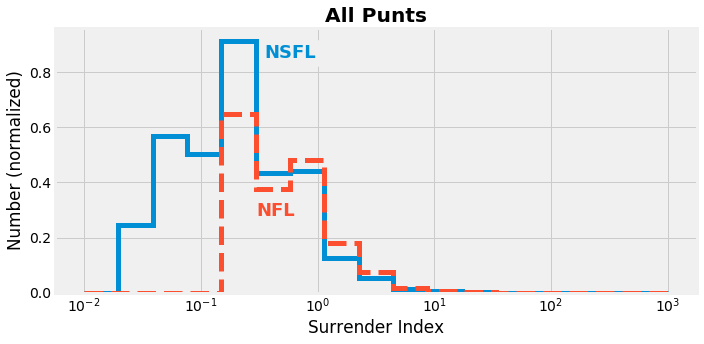

In [27]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('All Punts',weight='bold')
plt.xlabel('Surrender Index')
plt.ylabel('Number (normalized)')
bins = np.logspace(-2,3,18)
plt.hist(puntDF['surrenderIndex'],bins=bins,histtype='step',color='C0',density=True,lw=5,label='NSFL')
plt.hist(NFL,bins=bins,color='C1',histtype='step',density=True,lw=5,ls='--',label='NFL')
plt.xscale('log')
plt.text(x=0.35,y=0.85,s='NSFL',c='C0',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.text(x=0.3,y=0.28,s='NFL',c='C1',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.tight_layout()
plt.savefig('images/surrenderindexes.png')
plt.show()

In [28]:
def touchback(row):
    if 'Touchback' in row['play']:
        return "Touchback"
    elif 'No return' in row['play']:
        return "No return"
    else:
        return "Returned"

In [29]:
def puntDist(row):
    if 'BLOCKED' in row.play:
        return 0
    elif 'Touchback' in row.play:
        return row.dist2goal - 20
    else:
        return int(row.play.split('of ')[-1].split(' yards')[0])

In [30]:
puntDF['result'] = puntDF.apply(lambda row : touchback(row),axis = 1)

In [31]:
puntDF['scoreDiff'] = puntDF.apply(lambda row : scoreDiff(row),axis = 1)

In [32]:
puntDF['puntDist'] = puntDF.apply(lambda row : puntDist(row),axis = 1)

In [33]:
puntDF['puntEndLoc'] = puntDF['dist2goal'] - puntDF['puntDist']

In [34]:
puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','recTeam','down','distance','dist2goal','puntDist','puntEndLoc','surrenderIndex','percentiles','NFLpercentiles','play','result']]

In [35]:
puntDF[(puntDF['gameID'] == 2575) & (puntDF['recTeam'] == 'OCO')].sort_values('surrenderIndex',ascending=False)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,percentiles,NFLpercentiles,play,result
117146,10,2575,2,4:08,COL,7,0,OCO,OCO,4.0,14.0,36.0,16.0,20.0,6.660308,86.242681,88.870306,"Punt by McCormick, M. of 36 yards. Touchback.",Touchback
382413,10,2575,2,4:08,COL,7,0,OCO,OCO,4.0,14.0,36.0,16.0,20.0,6.660308,86.242681,88.870306,"Punt by McCormick, M. of 36 yards. Touchback.",Touchback
382368,10,2575,1,6:06,COL,0,0,OCO,OCO,4.0,10.0,45.0,25.0,20.0,2.581624,74.661566,71.992593,"Punt by McCormick, M. of 45 yards. Touchback.",Touchback
117101,10,2575,1,6:06,COL,0,0,OCO,OCO,4.0,10.0,45.0,25.0,20.0,2.581624,74.661566,71.992593,"Punt by McCormick, M. of 45 yards. Touchback.",Touchback
117169,10,2575,2,0:22,COL,7,3,OCO,OCO,4.0,3.0,63.0,32.0,31.0,0.800000,46.860382,35.567236,"Punt by McCormick, M. of 32 yards.",Returned
382436,10,2575,2,0:22,COL,7,3,OCO,OCO,4.0,3.0,63.0,32.0,31.0,0.800000,46.860382,35.567236,"Punt by McCormick, M. of 32 yards.",Returned
382421,10,2575,2,1:54,COL,7,0,OCO,OCO,4.0,6.0,93.0,37.0,56.0,0.600000,34.201233,22.910445,"Punt by McCormick, M. of 37 yards.",Returned
117154,10,2575,2,1:54,COL,7,0,OCO,OCO,4.0,6.0,93.0,37.0,56.0,0.600000,34.201233,22.910445,"Punt by McCormick, M. of 37 yards.",Returned
117083,10,2575,1,14:12,COL,0,0,OCO,OCO,4.0,14.0,61.0,59.0,2.0,0.400000,25.431368,14.231673,"Punt by McCormick, M. of 59 yards. No return.",No return
382350,10,2575,1,14:12,COL,0,0,OCO,OCO,4.0,14.0,61.0,59.0,2.0,0.400000,25.431368,14.231673,"Punt by McCormick, M. of 59 yards. No return.",No return


In [36]:
puntArr = []
for i in range(30,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntArr.append(i4df['result'].value_counts(normalize=True))

In [37]:
puntArr[3]['Touchback']

0.988950276243094

In [38]:
tbList = []
nrList = []
rList = []
for f in puntArr:
    try:
        tbList.append(f['Touchback'])
    except KeyError:
        tbList.append(0.)
    try:
        nrList.append(f['No return'])
    except KeyError:
        nrList.append(0.)
    try:
        rList.append(f['Returned'])
    except KeyError:
        rList.append(0.)

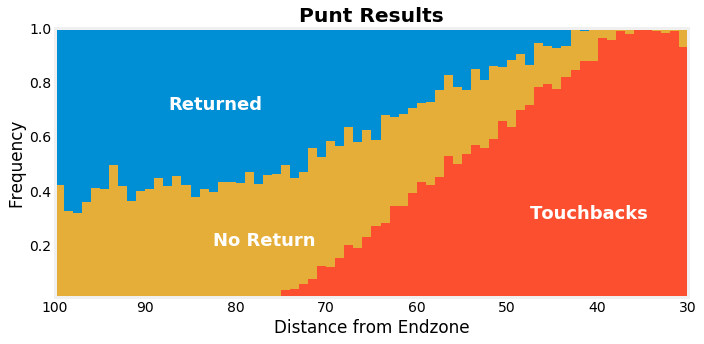

In [39]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,rList,bottom=[tbList[i]+nrList[i] for i in range(len(yardRange))],width=1,label='Returned',color='C0',align='edge')
plt.bar(yardRange,nrList,bottom=tbList,width=1,label='No Return',color='C2',align='edge')
plt.bar(yardRange,tbList,width=1,label='Touchback',color='C1',align='edge')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 47.5, y = 0.3, s = 'Touchbacks', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 82.5, y = 0.2, s = 'No Return', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 87.5, y = 0.7, s = 'Returned', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100,30)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results.png')
plt.show()

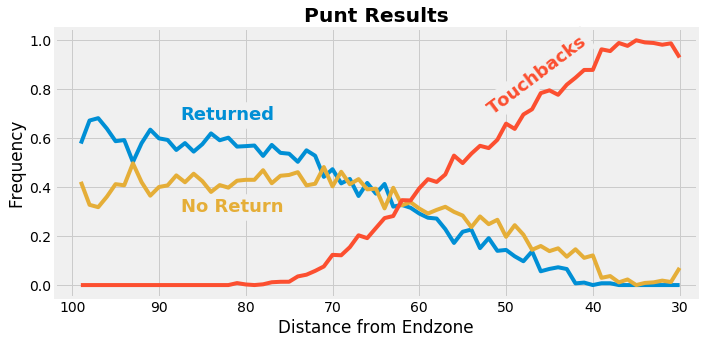

In [40]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,rList,label='Returned',color='C0')
plt.plot(yardRange,nrList,label='No Return',color='C2')
plt.plot(yardRange,tbList,label='Touchback',color='C1')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 52.5, y = 0.7, s = 'Touchbacks', color = 'C1', weight = 'bold', size = 18, rotation = 37, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.3, s = 'No Return', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.675, s = 'Returned', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results_line.png')
plt.show()

In [41]:
puntDF[puntDF['result'] == 'Touchback'].sort_values('dist2goal',ascending=False).head(5)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,percentiles,NFLpercentiles,play,result
39534,4,757,3,13:14,ARI,7,13,LV,LV,4.0,6.0,81.0,61.0,20.0,2.402858,73.540163,70.624776,"Punt by Ronaldo, C. of 80 yards. Touchback.",Touchback
300691,4,757,3,13:14,ARI,7,13,LV,LV,4.0,6.0,81.0,61.0,20.0,2.402858,73.540163,70.624776,"Punt by Ronaldo, C. of 80 yards. Touchback.",Touchback
206176,18,4563,2,3:57,CHI,13,17,YKW,YKW,4.0,2.0,81.0,61.0,20.0,3.200000,77.875530,76.824752,"Punt by Fulture, K. of 80 yards. Touchback.",Touchback
478254,18,4563,2,3:57,CHI,13,17,YKW,YKW,4.0,2.0,81.0,61.0,20.0,3.200000,77.875530,76.824752,"Punt by Fulture, K. of 80 yards. Touchback.",Touchback
57565,6,1583,4,11:24,PHI,17,27,BAL,PHI,4.0,10.0,80.0,60.0,20.0,0.200000,12.691676,4.254768,"Punt by Turkleton, T. of 80 yards. Touchback.",Touchback


In [42]:
puntDF[puntDF.S == 20].sort_values('surrenderIndex',ascending=False).head(5)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,percentiles,NFLpercentiles,play,result
514165,20,5005,2,4:20,BAL,13,10,CHI,BAL,4.0,2.0,33.0,13.0,20.0,184.144187,99.524488,99.948234,"Punt by Fulture, K. of 33 yards. Touchback.",Touchback
239185,20,5005,2,4:20,BAL,13,10,CHI,BAL,4.0,2.0,33.0,13.0,20.0,184.144187,99.524488,99.948234,"Punt by Fulture, K. of 33 yards. Touchback.",Touchback
520278,20,5033,4,3:05,COL,13,14,NO,NO,4.0,22.0,37.0,17.0,20.0,115.718037,99.180633,99.888504,"Punt by Jackson (R), J. of 37 yards. Touchback.",Touchback
245298,20,5033,4,3:05,COL,13,14,NO,NO,4.0,22.0,37.0,17.0,20.0,115.718037,99.180633,99.888504,"Punt by Jackson (R), J. of 37 yards. Touchback.",Touchback
236351,20,4991,4,10:28,YKW,20,14,BAL,YKW,4.0,2.0,41.0,21.0,20.0,111.769164,99.112481,99.868594,"Punt by Brand, F. of 41 yards. Touchback.",Touchback


In [43]:
puntDF.columns

Index(['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'recTeam', 'down', 'distance', 'dist2goal', 'puntDist',
       'puntEndLoc', 'surrenderIndex', 'percentiles', 'NFLpercentiles', 'play',
       'result'],
      dtype='object')

In [44]:
puntDF['surrenderRank'] = puntDF.surrenderIndex.rank(method='max',ascending=False)
puntDF = puntDF[['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'recTeam', 'down', 'distance', 'dist2goal', 'puntDist',
       'puntEndLoc', 'surrenderIndex','surrenderRank', 'percentiles', 'NFLpercentiles', 'play',
       'result']]

In [45]:
puntDF.sort_values('surrenderIndex',ascending=False).head(5)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,result
322060,6,1592,5,12:29,YKW,27,27,NO,YKW,4.0,2.0,32.0,12.0,20.0,930.991208,2.0,99.998451,100.0,"Punt by Lombardi, J. of 32 yards. Touchback.",Touchback
59534,6,1592,5,12:29,YKW,27,27,NO,YKW,4.0,2.0,32.0,12.0,20.0,930.991208,2.0,99.998451,100.0,"Punt by Lombardi, J. of 32 yards. Touchback.",Touchback
123818,11,2698,4,4:24,YKW,21,17,PHI,YKW,4.0,1.0,35.0,15.0,20.0,739.114908,4.0,99.992256,100.0,"Punt by (R) Fulture, K. of 35 yards. Touchback.",Touchback
389715,11,2698,4,4:24,YKW,21,17,PHI,YKW,4.0,1.0,35.0,15.0,20.0,739.114908,4.0,99.992256,100.0,"Punt by (R) Fulture, K. of 35 yards. Touchback.",Touchback
259549,1,18,4,2:03,BAL,20,23,COL,COL,4.0,3.0,35.0,15.0,20.0,730.985378,6.0,99.986060,100.0,"Punt by Harris, S. of 35 yards. Touchback.",Touchback


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a45474bd0>]],
      dtype=object)

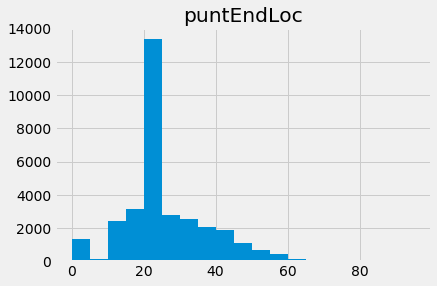

In [46]:
puntDF.hist('puntEndLoc',bins=np.arange(0,100,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a44e6b290>]],
      dtype=object)

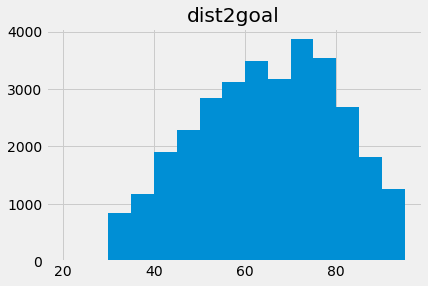

In [47]:
puntDF.hist('dist2goal',bins=np.arange(20,100,5))

In [48]:
min(puntDF.dist2goal)

30.0

In [49]:
puntEndArr = []
for i in range(0,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntEndArr.append(i4df['puntEndLoc'].value_counts(normalize=True))

In [50]:
in20 = 0
tb = 0
out20 = 0
for key,val in puntEndArr[30].items():
    if key < 20:
        in20 += val
    elif key == 20:
        tb += val
    else:
        out20 += val
print(in20, tb, out20)

0.03508771929824561 0.9298245614035088 0.03508771929824561


In [51]:
in20List = []
tb20List = []
out20List = []
for f in puntEndArr[30:]:
    in20 = 0
    tb = 0
    out20 = 0
    for key,val in f.items():
        if key < 20:
            in20 += val
        elif key == 20:
            tb += val
        else:
            out20 += val
    in20List.append(in20)
    tb20List.append(tb)
    out20List.append(out20)

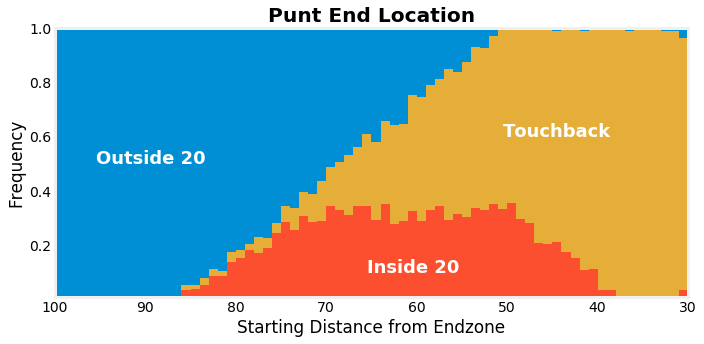

In [52]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt End Location',weight='bold')
plt.xlabel('Starting Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,out20List,bottom=[tb20List[i]+in20List[i] for i in range(len(yardRange))],width=1,label='Outside 20',color='C0',align='edge')
plt.bar(yardRange,tb20List,bottom=in20List,width=1,label='Touchback',color='C2',align='edge')
plt.bar(yardRange,in20List,width=1,label='Inside 20',color='C1',align='edge')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 65.5, y = 0.1, s = 'Inside 20', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 50.5, y = 0.6, s = 'Touchback', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 95.5, y = 0.5, s = 'Outside 20', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100,30)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results.png')
plt.show()

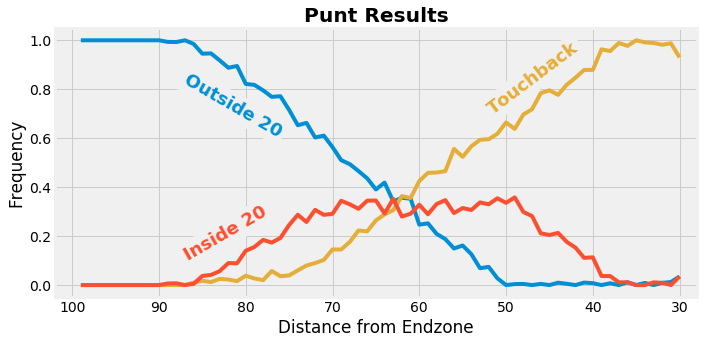

In [53]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,out20List,label='Outside 20',color='C0')
plt.plot(yardRange,tb20List,label='Touchback',color='C2')
plt.plot(yardRange,in20List,label='Inside 20',color='C1')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 52.5, y = 0.7, s = 'Touchback', color = 'C2', weight = 'bold', size = 18, rotation = 37, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.1, s = 'Inside 20', color = 'C1', weight = 'bold', size = 18, rotation = 30, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.605, s = 'Outside 20', color = 'C0', weight = 'bold', size = 18, rotation = -30,backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results_line.png')
plt.show()

In [54]:
puntDF[puntDF.puntEndLoc < 20].sort_values('dist2goal',ascending = False).head(10)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,result
238597,20,5002,3,10:25,AUS,3,13,AZ,AZ,4.0,9.0,89.0,71.0,18.0,1.224956,12824.0,60.281590,51.495242,"Punt by Crisco, A. of 71 yards. No return.",No return
513577,20,5002,3,10:25,AUS,3,13,AZ,AZ,4.0,9.0,89.0,71.0,18.0,1.224956,12824.0,60.281590,51.495242,"Punt by Crisco, A. of 71 yards. No return.",No return
26620,3,306,1,5:12,ARI,3,0,YKW,YKW,4.0,10.0,88.0,69.0,19.0,0.200000,29568.0,12.691676,4.254768,"Punt by Ronaldo, C. of 69 yards. No return.",No return
287088,3,306,1,5:12,ARI,3,0,YKW,YKW,4.0,10.0,88.0,69.0,19.0,0.200000,29568.0,12.691676,4.254768,"Punt by Ronaldo, C. of 69 yards. No return.",No return
166360,15,3360,3,2:29,PHI,16,13,SJS,SJS,4.0,16.0,86.0,67.0,19.0,0.200000,29568.0,12.691676,4.254768,"Punt by Fulture, K. of 67 yards.",Returned
434840,15,3360,3,2:29,PHI,16,13,SJS,SJS,4.0,16.0,86.0,67.0,19.0,0.200000,29568.0,12.691676,4.254768,"Punt by Fulture, K. of 67 yards.",Returned
498615,19,4838,1,3:13,AZ,0,7,AUS,AZ,4.0,15.0,85.0,67.0,18.0,0.800000,18657.0,46.860382,35.567236,"Punt by Crisco, A. of 67 yards. No return.",No return
344920,7,1785,4,9:13,AZ,17,45,OCO,OCO,4.0,5.0,85.0,67.0,18.0,5.290373,5118.0,84.148570,86.118743,"Punt by Jackson, D. of 67 yards.",Returned
241889,20,5018,1,3:01,PHI,3,7,OCO,OCO,4.0,17.0,85.0,66.0,19.0,0.800000,18657.0,46.860382,35.567236,"Punt by Powers (R), V. of 66 yards. No return.",No return
213618,18,4599,1,3:24,AUS,7,7,CHI,CHI,4.0,29.0,85.0,68.0,17.0,0.400000,25450.0,25.431368,14.231673,"Punt by Crisco, A. of 68 yards.",Returned


In [55]:
puntDF.to_csv('allpunts.csv')

In [56]:
puntDF.sort_values('surrenderIndex',ascending=False).head(35)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,result
322060,6,1592,5,12:29,YKW,27,27,NO,YKW,4.0,2.0,32.0,12.0,20.0,930.991208,2.0,99.998451,100.000000,"Punt by Lombardi, J. of 32 yards. Touchback.",Touchback
59534,6,1592,5,12:29,YKW,27,27,NO,YKW,4.0,2.0,32.0,12.0,20.0,930.991208,2.0,99.998451,100.000000,"Punt by Lombardi, J. of 32 yards. Touchback.",Touchback
123818,11,2698,4,4:24,YKW,21,17,PHI,YKW,4.0,1.0,35.0,15.0,20.0,739.114908,4.0,99.992256,100.000000,"Punt by (R) Fulture, K. of 35 yards. Touchback.",Touchback
389715,11,2698,4,4:24,YKW,21,17,PHI,YKW,4.0,1.0,35.0,15.0,20.0,739.114908,4.0,99.992256,100.000000,"Punt by (R) Fulture, K. of 35 yards. Touchback.",Touchback
259549,1,18,4,2:03,BAL,20,23,COL,COL,4.0,3.0,35.0,15.0,20.0,730.985378,6.0,99.986060,100.000000,"Punt by Harris, S. of 35 yards. Touchback.",Touchback
361,1,18,4,2:03,BAL,20,23,COL,COL,4.0,3.0,35.0,15.0,20.0,730.985378,6.0,99.986060,100.000000,"Punt by Harris, S. of 35 yards. Touchback.",Touchback
288980,3,314,4,3:16,PHI,14,17,YKW,YKW,4.0,5.0,33.0,13.0,20.0,708.052379,8.0,99.979864,100.000000,"Punt by Harris, S. of 33 yards. Touchback.",Touchback
28512,3,314,4,3:16,PHI,14,17,YKW,YKW,4.0,5.0,33.0,13.0,20.0,708.052379,8.0,99.979864,100.000000,"Punt by Harris, S. of 33 yards. Touchback.",Touchback
338035,7,1754,4,8:30,YKW,23,20,SJS,YKW,4.0,3.0,32.0,12.0,20.0,695.333384,10.0,99.973669,100.000000,"Punt by Blewitt, I. of 32 yards. Touchback.",Touchback
74813,7,1754,4,8:30,YKW,23,20,SJS,YKW,4.0,3.0,32.0,12.0,20.0,695.333384,10.0,99.973669,100.000000,"Punt by Blewitt, I. of 32 yards. Touchback.",Touchback


In [57]:
puntDF[puntDF.S == 21].sort_values('surrenderIndex',ascending=False)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,result
255255,21,5199,4,8:27,CHI,14,7,PHI,CHI,4.0,7.0,31.0,11.0,20.0,419.190346,34.0,99.899322,99.996018,"Punt by Powers, V. of 31 yards. Touchback.",Touchback
531782,21,5199,4,8:27,CHI,14,7,PHI,CHI,4.0,7.0,31.0,11.0,20.0,419.190346,34.0,99.899322,99.996018,"Punt by Powers, V. of 31 yards. Touchback.",Touchback
245979,21,5155,4,4:06,PHI,26,20,COL,PHI,4.0,8.0,34.0,14.0,20.0,364.665295,42.0,99.874539,99.992036,"Punt by Banana (R), S. of 34 yards. Touchback.",Touchback
522506,21,5155,4,4:06,PHI,26,20,COL,PHI,4.0,8.0,34.0,14.0,20.0,364.665295,42.0,99.874539,99.992036,"Punt by Banana (R), S. of 34 yards. Touchback.",Touchback
254633,21,5196,4,6:58,AUS,30,16,CHI,AUS,4.0,2.0,35.0,15.0,20.0,349.060168,46.0,99.862148,99.992036,"Punt by Espinosa, D. of 35 yards. Touchback.",Touchback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258255,21,5214,3,14:42,OCO,0,21,BAL,OCO,4.0,10.0,59.0,58.0,1.0,0.032702,32281.0,0.125461,0.000000,"Punt by Fulture, K. of 58 yards. No return.",No return
534161,21,5211,3,13:20,SJS,9,13,PHI,SJS,4.0,13.0,59.0,39.0,20.0,0.032702,32281.0,0.125461,0.000000,"Punt by Powers, V. of 59 yards. Touchback.",Touchback
532912,21,5205,1,3:40,AUS,3,0,COL,COL,4.0,13.0,59.0,57.0,2.0,0.032702,32281.0,0.125461,0.000000,"Punt by Crisco, A. of 57 yards. No return.",No return
530698,21,5194,3,6:39,PHI,27,13,BAL,BAL,4.0,10.0,59.0,39.0,20.0,0.032702,32281.0,0.125461,0.000000,"Punt by Powers, V. of 58 yards. Touchback.",Touchback


## Fourth Downs

In [58]:
fourthDF = allData[allData['down'] == 4.0]

In [59]:
def playType(play):
#     print(play)
    if 'Punt' in play:
        ptype = 'Punt'
    elif 'FG' in play:
        ptype = 'FG'
    elif 'Timeout' in play:
        ptype = 'Timeout'
    else:
        ptype = 'Try'
    return ptype

In [60]:
fourthDF = fourthDF.rename(columns = {'teamPoss':'recTeam'})

In [61]:
fourthDF['playType'] = fourthDF.apply(lambda row : playType(row['play']),axis=1)

In [62]:
def fixAZBug2(row):
    try:
        if row['recTeam'] == 'AZ' and row['playType'] == 'Punt':
            row['dist2goal'] = 100 - row['dist2goal']
            if row['homeTeam'] == 'AZ':
                row['side'] = row['awayTeam']
            else:
                row['side'] = row['homeTeam']
        return row
    except KeyError:
        return row

In [63]:
fourthDF = fourthDF.apply(lambda row : fixAZBug2(row),axis=1)

In [64]:
fourthDF['scoreDiff'] = fourthDF.apply(lambda row : scoreDiff(row),axis=1)

In [65]:
fourthDF = fourthDF[~fourthDF['playType'].str.contains('Timeout')]

In [66]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Penalty')]

In [67]:
fourthTryDF = fourthDF[fourthDF['playType'] == 'Try']

In [68]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Turnover')]

In [69]:
fourthDF['playType'].value_counts(normalize=True)

Punt    0.717531
FG      0.191425
Try     0.091044
Name: playType, dtype: float64

In [70]:
fourthArr = []
for i in range(1,100):
    i4df = fourthDF[fourthDF['dist2goal'] == i]
    fourthArr.append(i4df['playType'].value_counts(normalize=True))

In [71]:
fourthArr[0]['FG']

0.9471544715447154

In [72]:
FGlist = []
PuntList = []
TryList = []
TOList = []
for f in fourthArr:
    try:
        FGlist.append(f['FG'])
    except KeyError:
        FGlist.append(0.)
    try:
        PuntList.append(f['Punt'])
    except KeyError:
        PuntList.append(0.)
    try:
        TryList.append(f['Try'])
    except KeyError:
        TryList.append(0.)
    try:
        TOList.append(f['Timeout'])
    except KeyError:
        TOList.append(0.)

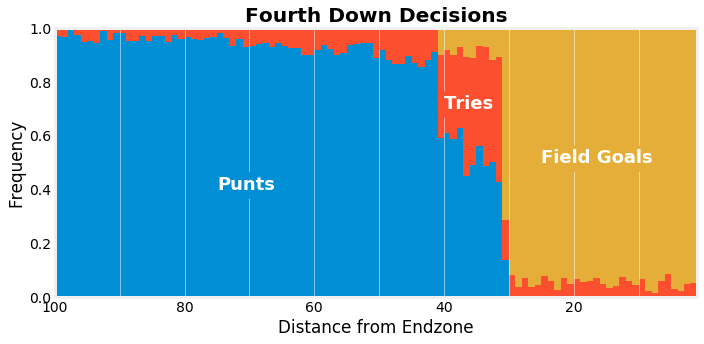

In [73]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,FGlist,bottom=[TryList[i]+PuntList[i] for i in range(99)],width=1,label='Field Goals',color='C2',align='edge')
plt.bar(yardRange,TryList,bottom=PuntList,width=1,label='Tries',color='C1',align='edge')
plt.bar(yardRange,PuntList,width=1,label='Punts',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(100,1)
plt.ylim(0,1)
plt.text(x = 40, y = 0.7, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 25, y = 0.5, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 75, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
# plt.legend(loc=5)
plt.tight_layout()
plt.savefig('images/4thdownbar.png')
plt.show()

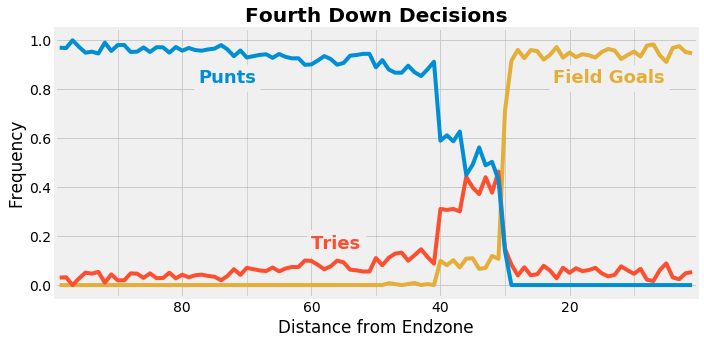

In [74]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
for i in [10,30,50,70,90]:
    plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
plt.xlim(99.75,0.25)
# plt.ylim(0,1)
# plt.legend(loc=5)
plt.text(x = 60, y = 0.15, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 22.5, y = 0.825, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 77.5, y = 0.825, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdownline.png')
plt.show()

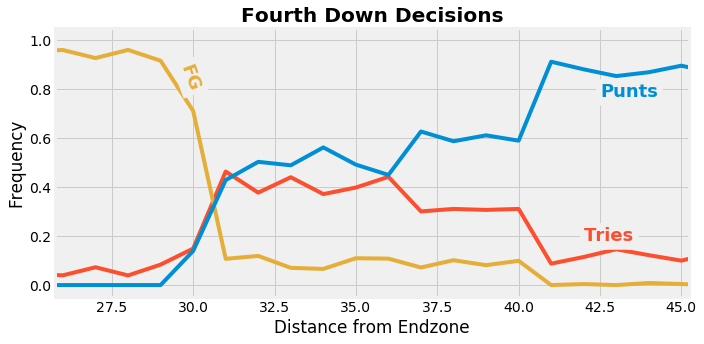

In [75]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
# plt.plot(yardRange,TOList,label='Timeouts',c='C3')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
# for i in [10,30,50,70,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.xlim(25.75,45.25)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 42, y = 0.18, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 29.5, y = 0.8, s = 'FG', color = 'C2', weight = 'bold', rotation = -70, size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 42.5, y = 0.77, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdown_dead.png')
plt.show()

In [76]:
deadZoneDF = fourthDF[(fourthDF['dist2goal'] <= 40) & (30 <= fourthDF['dist2goal'])]

In [77]:
len(deadZoneDF)

4533

In [78]:
deadZoneArr = []
deadZoneArrn = []
for i in range(1,51):
    i4df = deadZoneDF[deadZoneDF['distance'] == i]
    deadZoneArr.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrn.append(i4df['playType'].value_counts(normalize=False))

In [79]:
dFGlist = []
dPuntList = []
dTryList = []
dTOList = []
noneList = []

for f in deadZoneArr:
    i = 0
    try:
        dFGlist.append(f['FG'])
    except KeyError:
        dFGlist.append(0.)
        i += 1
    try:
        dPuntList.append(f['Punt'])
    except KeyError:
        dPuntList.append(0.)
        i+=1
    try:
        dTryList.append(f['Try'])
    except KeyError:
        dTryList.append(0.)

In [80]:
dFGlistn = []
dPuntListn = []
dTryListn = []
dTOListn = []
noneListn = []

for f in deadZoneArrn:
    i = 0
    try:
        dFGlistn.append(f['FG'])
    except KeyError:
        dFGlistn.append(0.)
        i += 1
    try:
        dPuntListn.append(f['Punt'])
    except KeyError:
        dPuntListn.append(0.)
        i+=1
    try:
        dTryListn.append(f['Try'])
    except KeyError:
        dTryListn.append(0.)

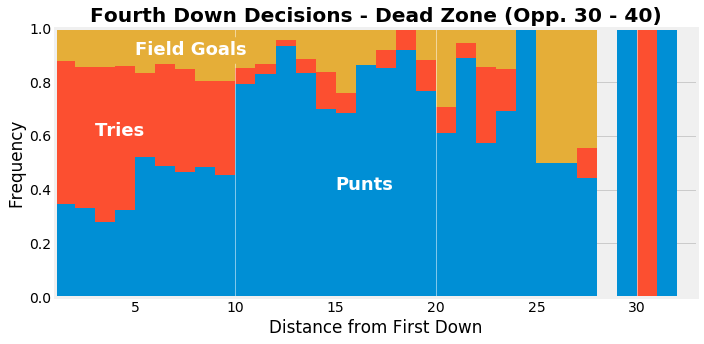

In [81]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntList,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryList,bottom=dPuntList,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlist,bottom=[dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 3, y = 0.6, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.9, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 15, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/4thdown_deadDist.png')
plt.show()

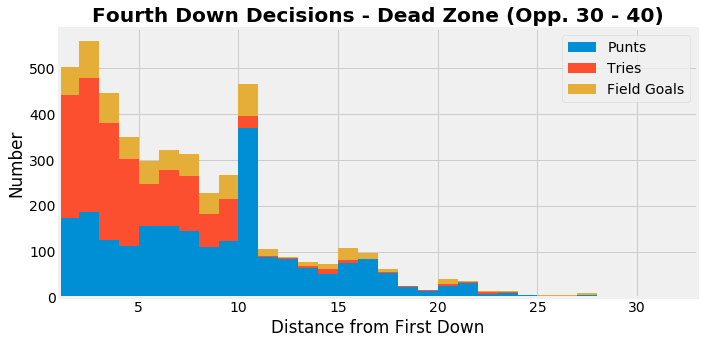

In [82]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListn,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListn,bottom=dPuntListn,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistn,bottom=[dTryListn[i]+dPuntListn[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.legend()
plt.tight_layout()
plt.savefig('images/4thdown_deadDist_total.png')
plt.show()

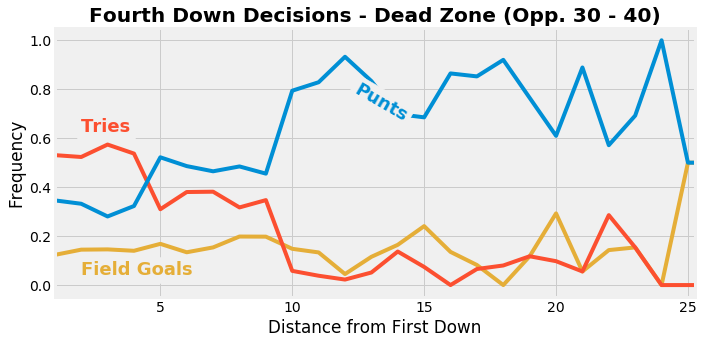

In [83]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.plot(yardRange,dFGlist,label='Field Goals',c='C2')
plt.plot(yardRange,dTryList,label='Tries',c='C1')
plt.plot(yardRange,dPuntList,label='Punts',c='C0')
# plt.plot(yardRange,dTOList,label='Timeouts')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,25.25)
# plt.ylim(0,1.01)
# plt.legend(loc=0)
plt.text(x = 2, y = 0.625, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 2, y = 0.04, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 12.25, y = 0.67, s = 'Punts', color = 'C0', weight = 'bold', rotation = -30, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdown_deadDist_line.png')
plt.show()

In [84]:
deadZoneDF4q = deadZoneDF[deadZoneDF['Q'] >= 4]
len(deadZoneDF4q)

1356

In [85]:
deadZoneArrPD = []
deadZoneArrPDn = []
for i in range(0,16):
    i4df = deadZoneDF4q[deadZoneDF4q['scoreDiff'] == i]
    deadZoneArrPD.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrPDn.append(i4df['playType'].value_counts(normalize=False))

In [86]:
dFGlistpd = []
dPuntListpd = []
dTryListpd = []
dTOListpd = []
noneListpd = []

for f in deadZoneArrPD:
    i = 0
    try:
        dFGlistpd.append(f['FG'])
    except KeyError:
        dFGlistpd.append(0.)
        i += 1
    try:
        dPuntListpd.append(f['Punt'])
    except KeyError:
        dPuntListpd.append(0.)
        i+=1
    try:
        dTryListpd.append(f['Try'])
    except KeyError:
        dTryListpd.append(0.)

In [87]:
dFGlistnpd = []
dPuntListnpd = []
dTryListnpd = []
dTOListnpd = []
noneListnpd = []

for f in deadZoneArrPDn:
    i = 0
    try:
        dFGlistnpd.append(f['FG'])
    except KeyError:
        dFGlistnpd.append(0.)
        i += 1
    try:
        dPuntListnpd.append(f['Punt'])
    except KeyError:
        dPuntListnpd.append(0.)
        i+=1
    try:
        dTryListnpd.append(f['Try'])
    except KeyError:
        dTryListnpd.append(0.)

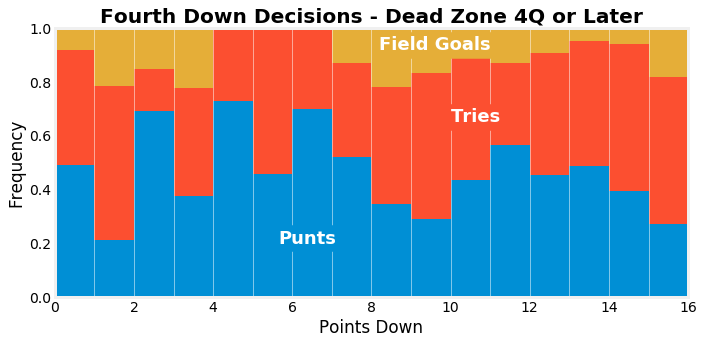

In [88]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone 4Q or Later',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntListpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListpd,bottom=dPuntListpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistpd,bottom=[dTryListpd[i]+dPuntListpd[i] for i in range(len(dFGlistpd))],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in range(16):
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 10, y = 0.65, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 8.2, y = 0.92, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 5.65, y = 0.2, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/4thdown_deadPD.png')
plt.show()

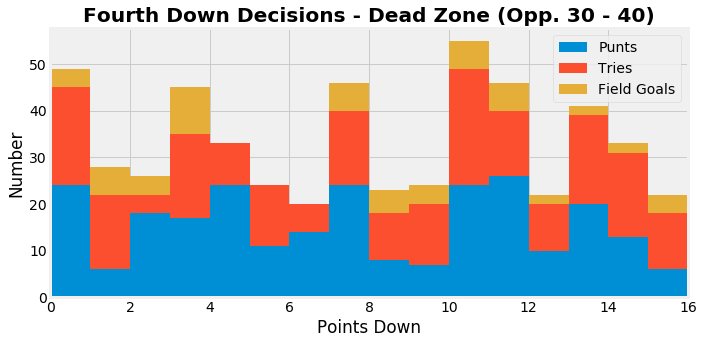

In [89]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListnpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListnpd,bottom=dPuntListnpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistnpd,bottom=[dTryListnpd[i]+dPuntListnpd[i] for i in range(16)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.legend()
plt.tight_layout()
plt.savefig('images/4thdown_deadPD_total.png')
plt.show()

## Field Goals

In [90]:
FGDF = allData[(allData['play'].str.contains('FG'))]

In [91]:
def fgDist(play):
    return int(play[:2])

In [92]:
FGDF['FGdist'] = FGDF.apply(lambda row : fgDist(row['play']),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
def fgRes(play):
    if 'BLOCKED' in play:
        return 'Block'
    elif 'NO good' in play:
        return 'Miss'
    else:
        return 'Good'

In [94]:
FGDF['FGresult'] = FGDF.apply(lambda row : fgRes(row['play']),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
FGDF['FGresult'].value_counts(normalize=True)

Good     0.874332
Miss     0.123362
Block    0.002306
Name: FGresult, dtype: float64

In [96]:
fgDistArr = []
fgDistArrn = []
fgRange = np.arange(20,100,5)
for i in fgRange:
    i4df = FGDF[(i-5 < FGDF['FGdist']) & (FGDF['FGdist'] <= i)]
    fgDistArr.append(i4df['FGresult'].value_counts(normalize=True))
    fgDistArrn.append(i4df['FGresult'].value_counts(normalize=False))

In [97]:
goodList = []
missList = []
blockList = []
for f in fgDistArr:
    try:
        goodList.append(f['Good'])
    except KeyError:
        goodList.append(0.)
    try:
        missList.append(f['Miss'])
    except KeyError:
        missList.append(0.)
    try:
        blockList.append(f['Block'])
    except KeyError:
        blockList.append(0.)

In [98]:
goodListn = []
missListn = []
blockListn = []
for f in fgDistArrn:
    try:
        goodListn.append(f['Good'])
    except KeyError:
        goodListn.append(0.)
    try:
        missListn.append(f['Miss'])
    except KeyError:
        missListn.append(0.)
    try:
        blockListn.append(f['Block'])
    except KeyError:
        blockListn.append(0.)

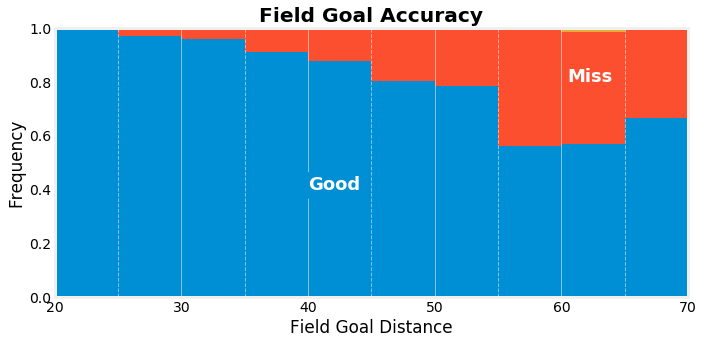

In [99]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Frequency')
plt.bar(fgRange,blockList,bottom=[goodList[i]+missList[i] for i in range(len(goodList))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missList,bottom=goodList,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodList,width=5,label='Good',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(20,70)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 60.5, y = 0.8, s = 'Miss', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.4, s = 'Good', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/fgResults.png')
plt.show()

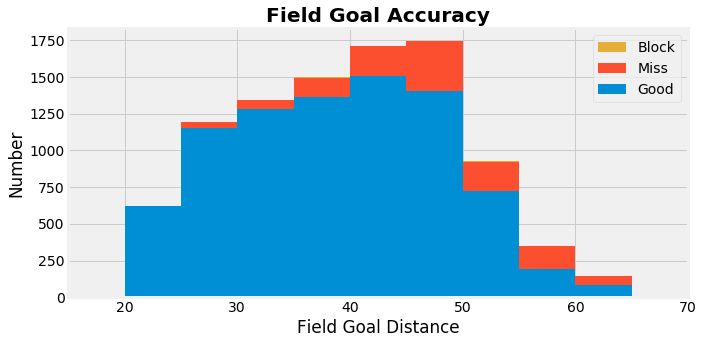

In [100]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Number')
plt.bar(fgRange,blockListn,bottom=[goodListn[i]+missListn[i] for i in range(len(goodListn))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missListn,bottom=goodListn,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodListn,width=5,label='Good',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
plt.xlim(15,70)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/fgResults_total.png')
plt.show()

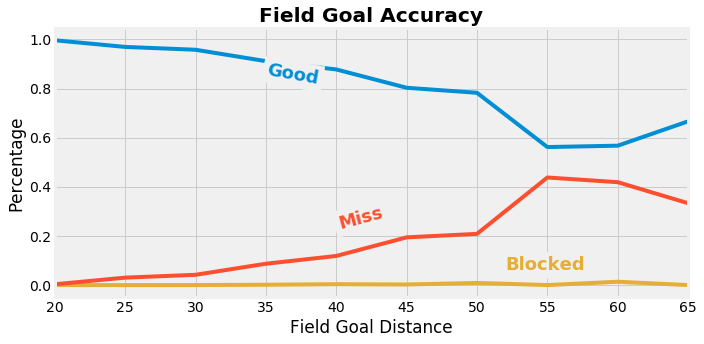

In [101]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Percentage')
plt.plot(fgRange,blockList,label='Block',c='C2')
plt.plot(fgRange,missList,label='Miss',c='C1')
plt.plot(fgRange,goodList,label='Good',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(20,65)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.23, s = 'Miss', color = 'C1', weight = 'bold', size = 18, rotation = 15, backgroundcolor = '#f0f0f0')
plt.text(x = 52, y = 0.06, s = 'Blocked', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 35, y = 0.82, s = 'Good', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/fgResults_line.png')
plt.show()

In [102]:
over50 = FGDF[FGDF.FGdist >= 50][['S','gameID','homeTeam','awayTeam','Q','time','down','distance','dist2goal','teamPoss','play','awayScore','homeScore','FGdist','FGresult']].sort_values('FGdist',ascending=False)

(array([68., 52., 75., 70., 68., 82., 76., 70.,  0.,  2.,  0.,  4.,  2.,
         0.,  2.,  4.]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 16 Patch objects>)

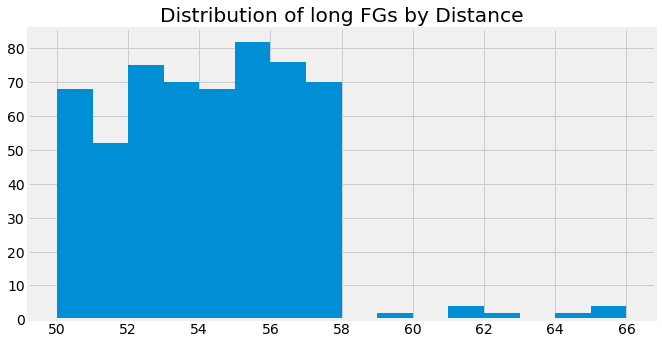

In [103]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5),facecolor='w')
plt.title('Distribution of long FGs by Distance')
plt.hist(over50['FGdist'],bins=np.arange(50,67,1))

In [104]:
FGDF[FGDF['FGresult'] == 'Block']

,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,teamPoss,dist2goal,awayScore,homeScore,FGdist,FGresult
11191,147,7,3,0:22,922,4.0,5.0,BAL,22.0,"39 yard FG by Harris, S. is BLOCKED by Nasher,...",84,2,PHI,BAL,PHI,22.0,27,14,39,Block
35387,102,6,2,0:08,1808,3.0,23.0,BAL,39.0,"56 yard FG by Blewitt, I. is BLOCKED by Valent...",738,4,SJS,BAL,SJS,39.0,7,7,56,Block
47847,57,8,2,12:03,2523,4.0,2.0,COL,29.0,"46 yard FG by Kicksit, B. is BLOCKED by Saint,...",1390,5,LV,COL,LV,29.0,13,0,46,Block
57408,25,7,1,6:50,3110,4.0,15.0,BAL,22.0,"39 yard FG by Harris, S. is BLOCKED by Dam, D..",1583,6,BAL,PHI,PHI,22.0,0,0,39,Block
155621,47,8,1,1:25,2785,4.0,5.0,PHI,25.0,"42 yard FG by Meoff, B. is BLOCKED by (R) Fort...",3214,14,PHI,NO,NO,25.0,7,14,42,Block
214673,84,1,2,0:11,1811,1.0,10.0,SJS,23.0,"40 yard FG by Brand, F. is BLOCKED by Riposte,...",4604,18,SJS,BAL,BAL,23.0,10,14,40,Block
226527,18,8,1,9:18,3258,4.0,4.0,OCO,25.0,"42 yard FG by Prohaska (R), H. is BLOCKED by A...",4845,19,NO,OCO,NO,25.0,7,0,42,Block
240716,170,1,4,5:36,336,4.0,2.0,SJS,29.0,"46 yard FG by Brand, F. is BLOCKED by Beck, C..",5012,20,BAL,SJS,BAL,29.0,27,20,46,Block
244557,109,9,2,0:05,1805,1.0,10.0,AUS,33.0,"50 yard FG by Fulture, K. is BLOCKED by Sexjok...",5030,20,CHI,AUS,CHI,33.0,17,6,50,Block
251472,129,3,3,10:27,1527,4.0,9.0,CHI,16.0,"33 yard FG by Banana (R), S. is BLOCKED by Rid...",5181,21,CHI,COL,COL,16.0,21,17,33,Block


## Drive Endings

In [105]:
todDF = allData[(allData['play'].str.contains('Turnover'))]

In [106]:
tdDF = allData[(allData['play'].str.contains('TOUCHDOWN'))]

In [107]:
safetyDF = allData[(allData['play'].str.contains('SAFETY'))]

In [108]:
intDF = allData[(allData['play'].str.contains('INTERCEPTION'))]

In [109]:
fumbleDF = allData[(allData['play'].str.contains('FUMBLE'))]

In [110]:
pies = [len(puntDF),len(FGDF),len(todDF),len(tdDF),len(intDF),len(fumbleDF),len(safetyDF)]

In [111]:
labels = ['Punts (%.2f%%)'%(len(puntDF)/sum(pies)*100),
          'FG Att (%.2f%%)'%(len(FGDF)/sum(pies)*100),
          'Turnover (%.2f%%)'%(len(todDF)/sum(pies)*100),
          'Touchdown (%.2f%%)'%(len(tdDF)/sum(pies)*100),
          'Interception (%.2f%%)'%(len(intDF)/sum(pies)*100),
          'Fumble (%.2f%%)'%(len(fumbleDF)/sum(pies)*100),
          'Safety (%.2f%%)'%(len(safetyDF)/sum(pies)*100)]

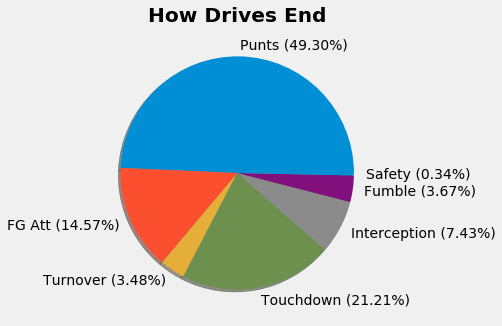

In [112]:
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.title('How Drives End',weight='bold')
plt.pie(pies,labels=labels,shadow=True)
plt.savefig('images/piechart.png')
plt.show()

## Tries

In [113]:
triesDF = fourthTryDF[(fourthTryDF['playType'] == 'Try')]

In [114]:
pd.set_option('display.max_columns', None)  

In [115]:
turnoverList = triesDF.index[triesDF['play'].str.contains('Turnover')].tolist()

In [116]:
intlist = triesDF.index[triesDF['play'].str.contains('INTERCEPTION')].tolist()

In [117]:
fumblelist = triesDF.index[triesDF['play'].str.contains('FUMBLE')].tolist()

In [118]:
turnoverList = [t-1 for t in turnoverList]
turnoverList = turnoverList + intlist + fumblelist

In [119]:
triesDF['tryResult'] = 'Good'

In [120]:
triesDF['tryResult'].loc[turnoverList] = 'Fail'

/home/mike/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [121]:
triesDF = triesDF[~triesDF['play'].str.contains('Turnover')]

In [122]:
triesDF['tryResult'].value_counts(normalize=True)

Fail    0.573975
Good    0.426025
Name: tryResult, dtype: float64

In [123]:
triesDistArr = []
triesDistArrn = []
triesRange = np.arange(1,40,1)
for i in triesRange:
    i4df = triesDF[triesDF['distance'] == i]
    triesDistArr.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn.append(i4df['tryResult'].value_counts(normalize=False))

In [124]:
triesgoodList = []
triesmissList = []
for f in triesDistArr:
    try:
        triesgoodList.append(f['Good'])
    except KeyError:
        triesgoodList.append(0.)
    try:
        triesmissList.append(f['Fail'])
    except KeyError:
        triesmissList.append(0.)

In [125]:
triesgoodListn = []
triesmissListn = []
for f in triesDistArrn:
    try:
        triesgoodListn.append(f['Good'])
    except KeyError:
        triesgoodListn.append(0.)
    try:
        triesmissListn.append(f['Fail'])
    except KeyError:
        triesmissListn.append(0.)

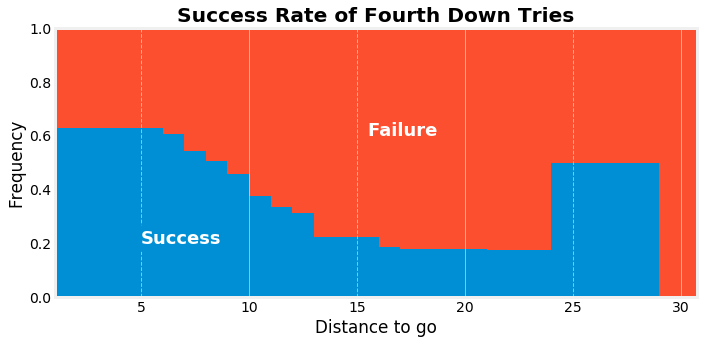

In [126]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.bar(triesRange,triesmissList,bottom=triesgoodList,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodList,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,30.75)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 15.5, y = 0.6, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/tryResults.png')
plt.show()

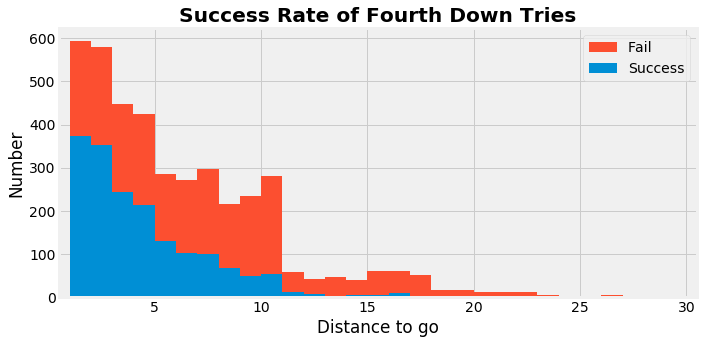

In [127]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Number')
plt.bar(triesRange,triesmissListn,bottom=triesgoodListn,width=1,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodListn,width=1,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/tryResults_total.png')
plt.show()

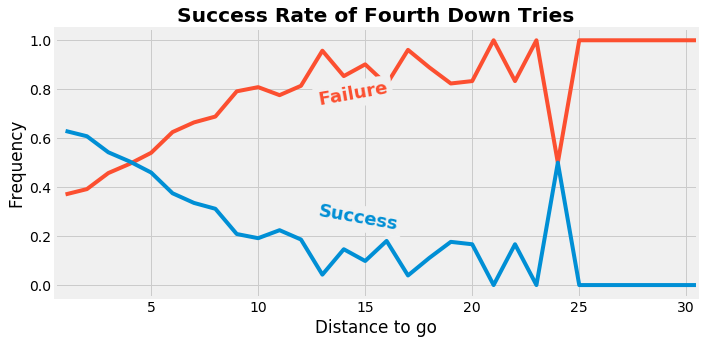

In [128]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.plot(triesRange,triesmissList,label='Fail',color='C1')
plt.plot(triesRange,triesgoodList,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 12.75, y = 0.735, s = 'Failure', color = 'C1', weight = 'bold', size = 18, rotation = 10, backgroundcolor = '#f0f0f0')
plt.text(x = 12.75, y = 0.225, s = 'Success', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/tryResults_line.png')
plt.show()

In [129]:
triesDistArr2 = []
triesDistArrn2 = []
triesRange2 = np.arange(0,100,5)
for i in triesRange2:
    i4df = triesDF[triesDF['dist2goal'] == i]
    triesDistArr2.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn2.append(i4df['tryResult'].value_counts(normalize=False))

In [130]:
triesgoodList2 = []
triesmissList2 = []
for f in triesDistArr2:
    try:
        triesgoodList2.append(f['Good'])
    except KeyError:
        triesgoodList2.append(0.)
    try:
        triesmissList2.append(f['Fail'])
    except KeyError:
        triesmissList2.append(0.)

In [131]:
triesgoodListn2 = []
triesmissListn2 = []
for f in triesDistArrn2:
    try:
        triesgoodListn2.append(f['Good'])
    except KeyError:
        triesgoodListn2.append(0.)
    try:
        triesmissListn2.append(f['Fail'])
    except KeyError:
        triesmissListn2.append(0.)

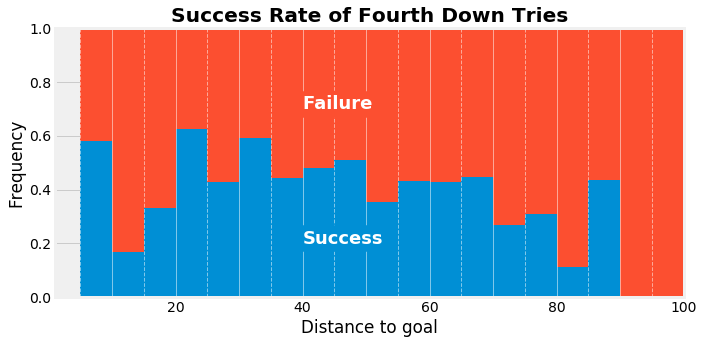

In [132]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.bar(triesRange2,triesmissList2,bottom=triesgoodList2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodList2,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65,75,85,95]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,100)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.7, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/tryResults_field.png')
plt.show()

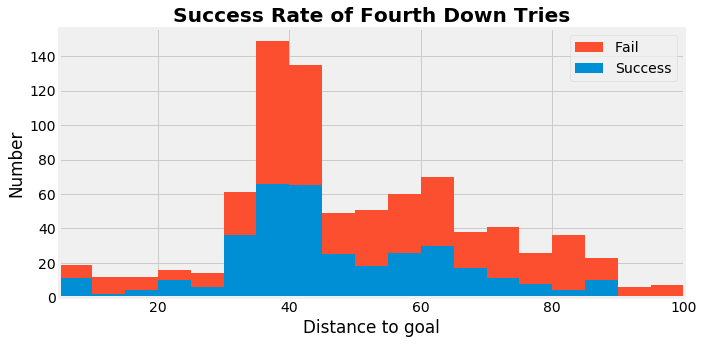

In [133]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Number')
plt.bar(triesRange2,triesmissListn2,bottom=triesgoodListn2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodListn2,width=5,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(5,100)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/tryResults_field_total.png')
plt.show()

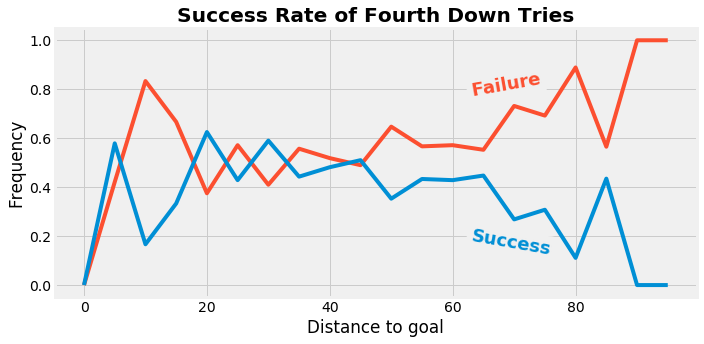

In [134]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.plot(triesRange2,triesmissList2,label='Fail',color='C1')
plt.plot(triesRange2,triesgoodList2,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
# plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 62.75, y = 0.775, s = 'Failure', color = 'C1', weight = 'bold', size = 18, rotation = 10, backgroundcolor = '#f0f0f0')
plt.text(x = 62.75, y = 0.125, s = 'Success', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/tryResults_field_line.png')
plt.show()

In [135]:
pd.set_option('display.max_colwidth', -1)
triesDF[(triesDF['distance']>=15) & (triesDF['tryResult'] == 'Good')].sort_values('distance',ascending=False)

,Unnamed: 0,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,recTeam,dist2goal,awayScore,homeScore,playType,scoreDiff,tryResult
154118,192,8,4,1:04,64,4.0,24.0,NO,23.0,"Pass by Maximus III, B., complete to Fyodorovich, V. for 24 yds. Tackle by Hondo, A..",3206,14,BAL,NO,NO,77.0,20,31,Try,11,Good
421996,192,8,4,1:04,64,4.0,24.0,NO,23.0,"Pass by Maximus III, B., complete to Fyodorovich, V. for 24 yds. Tackle by Hondo, A..",3206,14,BAL,NO,NO,77.0,20,31,Try,11,Good
130056,211,3,4,7:14,434,4.0,22.0,COL,18.0,"Pass by McCormick, M., complete to Wachter, J. for 33 yds. Tackle by Grithead, D..",2878,12,OCO,COL,COL,82.0,24,48,Try,24,Good
396673,211,3,4,7:14,434,4.0,22.0,COL,18.0,"Pass by McCormick, M., complete to Wachter, J. for 33 yds. Tackle by Grithead, D..",2878,12,OCO,COL,COL,82.0,24,48,Try,24,Good
252840,211,7,4,3:12,192,4.0,20.0,PHI,23.0,"Pass by Phoenix, B., complete to Vuxta, R. for 22 yds. Tackle by Rector, D..",5187,21,NO,PHI,PHI,77.0,9,33,Try,24,Good
529367,211,7,4,3:12,192,4.0,20.0,PHI,23.0,"Pass by Phoenix, B., complete to Vuxta, R. for 22 yds. Tackle by Rector, D..",5187,21,NO,PHI,PHI,77.0,9,33,Try,24,Good
43620,207,3,4,5:24,324,4.0,19.0,COL,33.0,"Pass by Pierno, N., complete to Tweed, B. for 22 yds. Tackle by Floggity, J..",776,4,YKW,COL,COL,67.0,0,31,Try,31,Good
461100,195,6,4,7:42,462,4.0,19.0,SJS,24.0,"Pass by Christ, J., complete to Flash, X. for 28 yds. Tackle by Lee, L..",3937,16,AZ,SJS,SJS,76.0,14,41,Try,27,Good
304777,207,3,4,5:24,324,4.0,19.0,COL,33.0,"Pass by Pierno, N., complete to Tweed, B. for 22 yds. Tackle by Floggity, J..",776,4,YKW,COL,COL,67.0,0,31,Try,31,Good
460276,209,10,4,2:08,128,4.0,18.0,PHI,48.0,"Pass by Cole (R), E., complete to Tidwell (R), R. for 43 yds. Tackle by Verden, J..",3933,16,PHI,AUS,AUS,48.0,13,31,Try,18,Good
